# Modelling Presidential Tweets

Balancing the data set in cell 3 by making trump tweets a random sample of 4400 to match obama+biden for classification... previously a 25,75 class imbalance.


We will model presidential tweets from Trump, Biden and Obama. We first try to use the tweets and NLP to create a model that will predict which president the tweet is from. We will then look at each president's sentiment scores and run a random forest to see which sentiment features have more importance in likes and retweets.

## Reading in, Concatenating Data

In [1]:
##Importing Libraries
import os
os.getcwd()
import random
# utilities
import re
import numpy as np
import pandas as pd
# plotting
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt
# nltk
from nltk.stem import WordNetLemmatizer
# sklearn
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report

# Import Libraries

from textblob import TextBlob
import sys
import tweepy
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import nltk
import pycountry
import re
import string


from wordcloud import WordCloud, STOPWORDS
from PIL import Image
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from langdetect import detect
from nltk.stem import SnowballStemmer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import CountVectorizer
nltk.download('vader_lexicon')


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/mauratoner/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [2]:
#saved in wd, reading in for modelling 
biden=pd.read_csv('POTUS_tweets.csv')
biden.head()
biden.shape #2402 tweets

obama=pd.read_csv('Obamawhitehouse_tweets.csv')
obama.head()
obama.shape #1919 tweets

# only want trump tweets during presidential term
Trump=pd.read_csv('trumptweets.csv')
Trump.head()
Trump.shape #41,122 tweets
#filtering on year
temp = []
for index, i in enumerate(Trump['date']):
    if i[0:4] in ['2017','2018','2019','2020']:    
        temp.append(index)
trump = Trump.loc[temp]
# want to take a random sample of 2400
random.seed(1234)
## MAKE BALANCED
trump =trump.sample(n=4400,replace=False)
trump=trump[['id','date','favorites','retweets','content']] #only want these columns so we can merge data
#renaming columns
trump.rename(columns = {'date':'created_at','favorites':'favorite_count','retweets':'retweet_count','content':'text'}, inplace = True)
trump=trump[['id','created_at','favorite_count','retweet_count','text']]
## ADDING NEW COLUMN 'pres' to indicate which president tweeted what
trump['pres']=np.repeat('Trump',len(trump))
biden['pres']=np.repeat('Biden',len(biden))
obama['pres']=np.repeat('Obama',len(obama))

In [3]:
#GETTINE ONE DATASET
pres_all=pd.concat([trump, biden,obama])
pres_all.reset_index(inplace=True)
pres_all.head()
pres_all['pres'].value_counts() #looks good
#Biden    2402
#Trump    2400
#Obama    1919
#Name: pres, dtype: int64

Trump    4400
Biden    2402
Obama    1919
Name: pres, dtype: int64

In [4]:
print('Total number of tweets being analyzed is:',len(pres_all))

Total number of tweets being analyzed is: 8721


In [5]:
pres_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8721 entries, 0 to 8720
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   index           8721 non-null   int64 
 1   id              8721 non-null   int64 
 2   created_at      8721 non-null   object
 3   favorite_count  8721 non-null   int64 
 4   retweet_count   8721 non-null   int64 
 5   text            8721 non-null   object
 6   pres            8721 non-null   object
dtypes: int64(4), object(3)
memory usage: 477.1+ KB


## Initial Sentiment Analysis

In [6]:
#making pie chart percentages easier via function
def percentage(part,whole):
    return 100 * float(part)/float(whole) 

#start sentiment analysis
#counts for each sentiment
positive  = 0
negative = 0
neutral = 0
polarity = 0
#list for tweets
tweet_list = []
#list for each sentiment 
neutral_list = []
negative_list = []
positive_list = []
#lists for favorite count, retweet count and date
favorite_list=[]
retweet_list=[]
tweet_date=[]

#loop through each tweet
for i in range(len(pres_all)):
    
    #print(tweet.text)
    tweet_list.append(pres_all['text'][i])
    favorite_list.append(pres_all['favorite_count'][i])
    retweet_list.append(pres_all['retweet_count'][i])
    tweet_date.append(pres_all['created_at'][i])
    analysis = TextBlob(pres_all['text'][i])
    #conduct sentiment analysis
    score = SentimentIntensityAnalyzer().polarity_scores(pres_all['text'][i])
    neg = score['neg'] #negative score
    neu = score['neu'] #neutral score
    pos = score['pos'] #positive score
    comp = score['compound']
    polarity += analysis.sentiment.polarity
    if neg > pos:
        negative_list.append(pres_all['text'][i])
        negative += 1

    elif pos > neg:
        positive_list.append(pres_all['text'][i])
        positive += 1
    
    elif pos == neg:
        neutral_list.append(pres_all['text'][i])
        neutral += 1

positive = percentage(positive, len(pres_all))
negative = percentage(negative, len(pres_all))
neutral = percentage(neutral, len(pres_all))
polarity = percentage(polarity, len(pres_all))
positive = format(positive, '.1f')
negative = format(negative, '.1f')
neutral = format(neutral, '.1f')



#Number of Tweets (Total, Positive, Negative, Neutral)
tweet_list = pd.DataFrame(tweet_list)
neutral_list = pd.DataFrame(neutral_list)
negative_list = pd.DataFrame(negative_list)
positive_list = pd.DataFrame(positive_list)
print("total number: ",len(tweet_list))
print("positive number: ",len(positive_list))
print("negative number: ", len(negative_list))
print("neutral number: ",len(neutral_list))

#View Tweets
tweet_list


total number:  8721
positive number:  5132
negative number:  2092
neutral number:  1497


,0
0,Give A$AP Rocky his FREEDOM. We do so much for...
1,"....impeaching him. They hate the fact, above ..."
2,"Today, it was my great honor to meet with the ..."
3,"Thank you for joining me in Mandan, ND Gov. @ ..."
4,"Rick Scott was up by 50,000+ votes on Election..."
...,...
8716,"“That’s America—one team, one nation.” —@POTUS..."
8717,"""We have to make it harder for people who want..."
8718,"""Our country isn’t just all about the Benjamin..."
8719,"""This is what a feminist looks like."" —@POTUS:..."


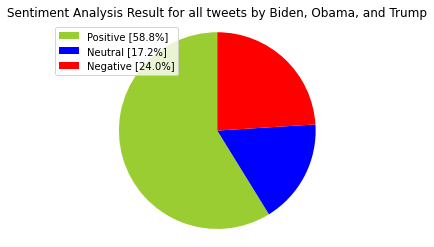

In [7]:
#Creating PieCart-- sentiment for all tweets regardless of president
labels = ['Positive ['+str(positive)+'%]' , 'Neutral ['+str(neutral)+'%]','Negative ['+str(negative)+'%]']
sizes = [positive, neutral, negative]
colors = ['yellowgreen', 'blue','red']
patches, texts = plt.pie(sizes,colors=colors, startangle=90)
plt.style.use('default')
plt.legend(labels)
plt.title("Sentiment Analysis Result for all tweets by Biden, Obama, and Trump" )
plt.axis('equal')
plt.show()

In [8]:
#drop duplicate tweets in case API pulled over twice
tweet_list.drop_duplicates(inplace = True)

# create data frame
tw_list = pd.DataFrame(tweet_list)
tw_list["text"] = tw_list[0]
tw_list

,0,text
0,Give A$AP Rocky his FREEDOM. We do so much for...,Give A$AP Rocky his FREEDOM. We do so much for...
1,"....impeaching him. They hate the fact, above ...","....impeaching him. They hate the fact, above ..."
2,"Today, it was my great honor to meet with the ...","Today, it was my great honor to meet with the ..."
3,"Thank you for joining me in Mandan, ND Gov. @ ...","Thank you for joining me in Mandan, ND Gov. @ ..."
4,"Rick Scott was up by 50,000+ votes on Election...","Rick Scott was up by 50,000+ votes on Election..."
...,...,...
8716,"“That’s America—one team, one nation.” —@POTUS...","“That’s America—one team, one nation.” —@POTUS..."
8717,"""We have to make it harder for people who want...","""We have to make it harder for people who want..."
8718,"""Our country isn’t just all about the Benjamin...","""Our country isn’t just all about the Benjamin..."
8719,"""This is what a feminist looks like."" —@POTUS:...","""This is what a feminist looks like."" —@POTUS:..."


In [9]:
pres_all

,index,id,created_at,favorite_count,retweet_count,text,pres
0,38495,1154502673514684416,2019-07-25 23:24:21,323554,91622,Give A$AP Rocky his FREEDOM. We do so much for...,Trump
1,40738,1206445927021662208,2019-12-16 06:28:18,40060,10150,"....impeaching him. They hate the fact, above ...",Trump
2,33184,936339260218724353,2017-11-30 22:00:50,41776,8695,"Today, it was my great honor to meet with the ...",Trump
3,32496,905582435538219011,2017-09-07 02:04:12,29668,5487,"Thank you for joining me in Mandan, ND Gov. @ ...",Trump
4,35922,1060949297900834816,2018-11-09 18:36:38,103784,29552,"Rick Scott was up by 50,000+ votes on Election...",Trump
...,...,...,...,...,...,...,...
8716,1914,743216376979005440,2016-06-15 22:59:27+00:00,824,362,"“That’s America—one team, one nation.” —@POTUS...",Obama
8717,1915,743193820058181632,2016-06-15 21:29:49+00:00,1354,606,"""We have to make it harder for people who want...",Obama
8718,1916,743174501072932865,2016-06-15 20:13:03+00:00,1112,507,"""Our country isn’t just all about the Benjamin...",Obama
8719,1917,743169414548230144,2016-06-15 19:52:50+00:00,785,350,"""This is what a feminist looks like."" —@POTUS:...",Obama


## Cleaning Tweets & Adding Sentiment Scores

In [10]:
#Removing RT, Punctuation, etc.
remove_rt = lambda x: re.sub('RT @\w+: '," ",x)
rt = lambda x: re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)"," ",x)
pres_all["text"] = pres_all.text.map(remove_rt).map(rt)
pres_all["text"] = pres_all.text.str.lower()
pres_all.head(10) #cleaned

,index,id,created_at,favorite_count,retweet_count,text,pres
0,38495,1154502673514684416,2019-07-25 23:24:21,323554,91622,give a ap rocky his freedom we do so much for...,Trump
1,40738,1206445927021662208,2019-12-16 06:28:18,40060,10150,impeaching him they hate the fact above ...,Trump
2,33184,936339260218724353,2017-11-30 22:00:50,41776,8695,today it was my great honor to meet with the ...,Trump
3,32496,905582435538219011,2017-09-07 02:04:12,29668,5487,thank you for joining me in mandan nd gov ...,Trump
4,35922,1060949297900834816,2018-11-09 18:36:38,103784,29552,rick scott was up by 50 000 votes on election...,Trump
5,33335,946460939578167296,2017-12-28 20:20:47,66796,22689,i ve been saying it for a long long time n...,Trump
6,40570,1202977723049795584,2019-12-06 16:46:54,12598,4204,heytammybruce this seems personal that it ...,Trump
7,34906,1024967606577573891,2018-08-02 12:38:15,92437,21976,charles koch of koch brothers who claims to b...,Trump
8,34052,990200773232529413,2018-04-28 14:07:16,83889,22070,allegations made by senator jon tester against...,Trump
9,35980,1063591994738515968,2018-11-17 01:37:46,97036,18006,congratulations to brian kemp on becoming the ...,Trump


In [11]:
pres_all['text_clean']=pres_all['text'].copy()
## extra cleaning
#removing urls
def cleaning_URLs(data):
    return re.sub('((www.[^s]+)|(https?://[^s]+))',' ',data)
pres_all['text_clean'] = pres_all['text_clean'].apply(lambda x: cleaning_URLs(x))

#removing numbers
def cleaning_numbers(data):
    return re.sub('[0-9]+', '', data)
pres_all['text_clean'] = pres_all['text_clean'].apply(lambda x: cleaning_numbers(x))
pres_all['text_clean'].tail()

#removing stopwords
stopwords = set(STOPWORDS)
stopwords.update(["m", "i", "s", "re", "potus",'u','isn','t','cc'])
def cleaning_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in stopwords])
pres_all['text_clean'] = pres_all['text_clean'].apply(lambda text: cleaning_stopwords(text))
pres_all['text_clean'].head()

#removing punctuation
import string
english_punctuations = string.punctuation
punctuations_list = english_punctuations
def cleaning_punctuations(text):
    translator = str.maketrans('', '', punctuations_list)
    return text.translate(translator)
pres_all['text_clean']= pres_all['text_clean'].apply(lambda x: cleaning_punctuations(x))
pres_all['text_clean'].tail()

#removing characters
def cleaning_repeating_char(text):
    return re.sub(r'(.)1+', r'1', text)
pres_all['text_clean'] = pres_all['text_clean'].apply(lambda x: cleaning_repeating_char(x))
pres_all['text_clean'].tail()

8716    america one team one nation unity wake attack ...
8717    make harder people want kill americans hands w...
8718        country benjamins tubmans stateofwomen summit
8719                          feminist looks stateofwomen
8720    today netneutrality ruling victory free fair i...
Name: text_clean, dtype: object

In [12]:
#Calculating Negative, Positive, Neutral and Compound values
pres_all[['polarity', 'subjectivity']] = pres_all['text_clean'].apply(lambda Text: pd.Series(TextBlob(Text).sentiment))
for index, row in pres_all['text_clean'].iteritems():
    score = SentimentIntensityAnalyzer().polarity_scores(row)
    neg = score['neg']
    neu = score['neu']
    pos = score['pos']
    comp = score['compound']
    if neg > pos:
        pres_all.loc[index, 'sentiment'] = "negative"
    elif pos > neg:
        pres_all.loc[index, 'sentiment'] = "positive"
    else:
        pres_all.loc[index, 'sentiment'] = "neutral"
    pres_all.loc[index, 'neg'] = neg
    pres_all.loc[index, 'neu'] = neu
    pres_all.loc[index, 'pos'] = pos
    pres_all.loc[index, 'compound'] = comp

pres_all.head(10) #added columns for sentiment scores


,index,id,created_at,favorite_count,retweet_count,text,pres,text_clean,polarity,subjectivity,sentiment,neg,neu,pos,compound
0,38495,1154502673514684416,2019-07-25 23:24:21,323554,91622,give a ap rocky his freedom we do so much for...,Trump,give ap rocky freedom much sweden doesn seem w...,0.200000,0.250000,negative,0.254,0.574,0.172,-0.2500
1,40738,1206445927021662208,2019-12-16 06:28:18,40060,10150,impeaching him they hate the fact above ...,Trump,impeaching hate fact president delivering subs...,-0.025000,0.450000,positive,0.211,0.569,0.221,-0.1779
2,33184,936339260218724353,2017-11-30 22:00:50,41776,8695,today it was my great honor to meet with the ...,Trump,today great honor meet crown prince bahrain wh...,0.400000,0.583333,positive,0.000,0.649,0.351,0.8979
3,32496,905582435538219011,2017-09-07 02:04:12,29668,5487,thank you for joining me in mandan nd gov ...,Trump,thank joining mandan nd gov dougburgum lt gov ...,0.000000,0.000000,positive,0.000,0.839,0.161,0.3612
4,35922,1060949297900834816,2018-11-09 18:36:38,103784,29552,rick scott was up by 50 000 votes on election...,Trump,rick scott votes election day now found many v...,0.500000,0.500000,neutral,0.000,1.000,0.000,0.0000
5,33335,946460939578167296,2017-12-28 20:20:47,66796,22689,i ve been saying it for a long long time n...,Trump,ve saying long long time nokopic twitter lqltg...,-0.050000,0.400000,neutral,0.000,1.000,0.000,0.0000
6,40570,1202977723049795584,2019-12-06 16:46:54,12598,4204,heytammybruce this seems personal that it ...,Trump,heytammybruce seems personal deeply unfair cha...,-0.166667,0.650000,negative,0.320,0.563,0.117,-0.6901
7,34906,1024967606577573891,2018-08-02 12:38:15,92437,21976,charles koch of koch brothers who claims to b...,Trump,charles koch koch brothers claims giving away ...,-0.177083,0.614583,negative,0.181,0.742,0.077,-0.4939
8,34052,990200773232529413,2018-04-28 14:07:16,83889,22070,allegations made by senator jon tester against...,Trump,allegations made senator jon tester admiral do...,-0.020000,0.740000,negative,0.291,0.546,0.163,-0.6013
9,35980,1063591994738515968,2018-11-17 01:37:46,97036,18006,congratulations to brian kemp on becoming the ...,Trump,congratulations brian kemp becoming new govern...,0.261837,0.602652,positive,0.085,0.415,0.500,0.9638


In [13]:
#Function for count_values_in single columns
tw_list_negative = pres_all[pres_all["sentiment"]=="negative"]['text']
tw_list_positive = pres_all[pres_all["sentiment"]=="positive"]['text']
tw_list_neutral = pres_all[pres_all["sentiment"]=="neutral"]['text']

#Function for count_values_in single columns
def count_values_in_column(data,feature):
    total=data.loc[:,feature].value_counts(dropna=False)
    percentage=round(data.loc[:,feature].value_counts(dropna=False,normalize=True)*100,2)
    return pd.concat([total,percentage],axis=1,keys=['Total','Percentage'])

#Count_values for sentiment
count_values_in_column(pres_all,"sentiment")

,Total,Percentage
positive,5234,60.02
negative,2046,23.46
neutral,1441,16.52


Word Cloud Saved Successfully


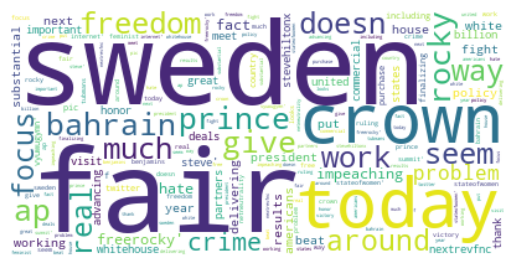

In [14]:
#Function to Create Wordcloud

def create_wordcloud(text):
    stopwords = set(STOPWORDS)
    stopwords.update(["m", "i", "s", "re", "potus",'u','st','nt','ii',"'"])
    wc = WordCloud(background_color="white",
                  max_words=3000,
                  stopwords=stopwords,
                  repeat=True)
    wc.generate(str(text))
    print("Word Cloud Saved Successfully")
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    plt.show()

#Creating wordcloud for all tweets
create_wordcloud(pres_all["text_clean"].values) #for all presidents

In [15]:
#check
pres_all.head() #new columns added

,index,id,created_at,favorite_count,retweet_count,text,pres,text_clean,polarity,subjectivity,sentiment,neg,neu,pos,compound
0,38495,1154502673514684416,2019-07-25 23:24:21,323554,91622,give a ap rocky his freedom we do so much for...,Trump,give ap rocky freedom much sweden doesn seem w...,0.200,0.250000,negative,0.254,0.574,0.172,-0.2500
1,40738,1206445927021662208,2019-12-16 06:28:18,40060,10150,impeaching him they hate the fact above ...,Trump,impeaching hate fact president delivering subs...,-0.025,0.450000,positive,0.211,0.569,0.221,-0.1779
2,33184,936339260218724353,2017-11-30 22:00:50,41776,8695,today it was my great honor to meet with the ...,Trump,today great honor meet crown prince bahrain wh...,0.400,0.583333,positive,0.000,0.649,0.351,0.8979
3,32496,905582435538219011,2017-09-07 02:04:12,29668,5487,thank you for joining me in mandan nd gov ...,Trump,thank joining mandan nd gov dougburgum lt gov ...,0.000,0.000000,positive,0.000,0.839,0.161,0.3612
4,35922,1060949297900834816,2018-11-09 18:36:38,103784,29552,rick scott was up by 50 000 votes on election...,Trump,rick scott votes election day now found many v...,0.500,0.500000,neutral,0.000,1.000,0.000,0.0000


# Exploratory Data Analysis
We will do wordclouds, time series plots and pie chart of sentiment for each president.

In [16]:
trump_eda=pres_all[pres_all['pres']=='Trump'] #isolate trump tweets and sentiments
biden_eda=pres_all[pres_all['pres']=='Biden'] #isolate biden tweets and sentiments
obama_eda=pres_all[pres_all['pres']=='Obama'] #isolate obama tweets and sentiments

### Biden EDA

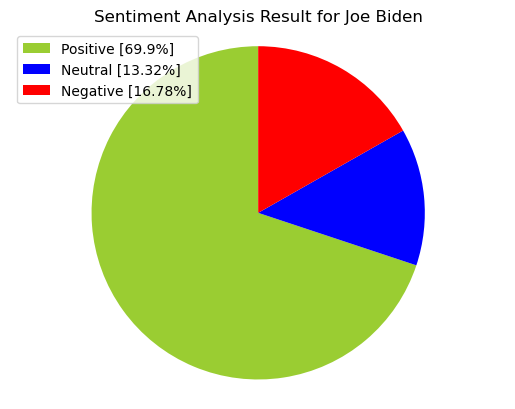

,Total,Percentage
positive,1679,69.90
negative,403,16.78
neutral,320,13.32


In [17]:
#percentages of each sentiment
perc_biden=count_values_in_column(biden_eda,"sentiment")
perc_biden
#Creating PieCart-- sentiment for all tweets regardless of president
labels = ['Positive ['+str(perc_biden['Percentage'][0])+'%]' , 'Neutral ['+str(perc_biden['Percentage'][2])+'%]','Negative ['+str(perc_biden['Percentage'][1])+'%]']
sizes = [(perc_biden['Percentage'][0]),(perc_biden['Percentage'][2]),(perc_biden['Percentage'][1])]
colors = ['yellowgreen', 'blue','red']
patches, texts = plt.pie(sizes,colors=colors, startangle=90)
plt.style.use('default')
plt.legend(labels)
plt.title("Sentiment Analysis Result for Joe Biden" )
plt.axis('equal')
plt.show()
perc_biden

Word Cloud Saved Successfully


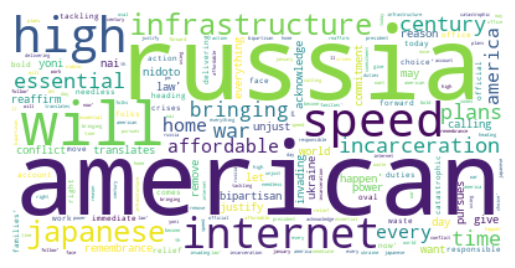

In [18]:
#Creating wordcloud
create_wordcloud(biden_eda["text_clean"].values) #for all presidents

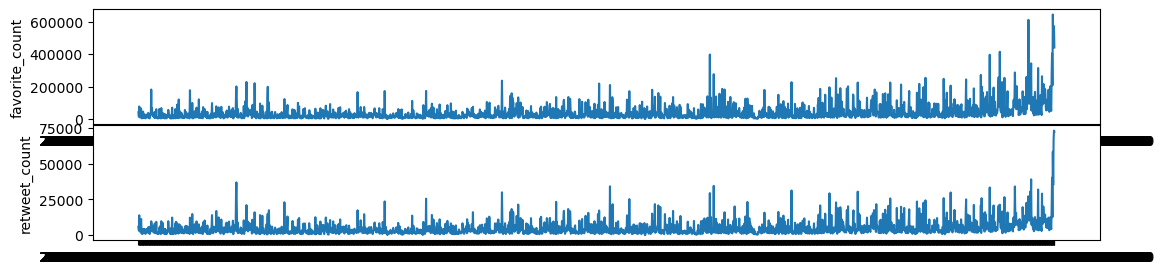

In [19]:
#EDA-- linechart
#favorite and retweet count over time

import matplotlib.pyplot as plt

ylabels = ["favorite_count","retweet_count"]
fig = plt.figure(figsize=(13,3))
fig.subplots_adjust(hspace=0.01,wspace=0.01)
n_row = len(ylabels)
n_col = 1
for count, ylabel in enumerate(ylabels):
    ax = fig.add_subplot(n_row,n_col,count+1)
    ax.plot(biden_eda["created_at"],biden_eda[ylabel])
    ax.set_ylabel(ylabel)
plt.show()

### Trump EDA

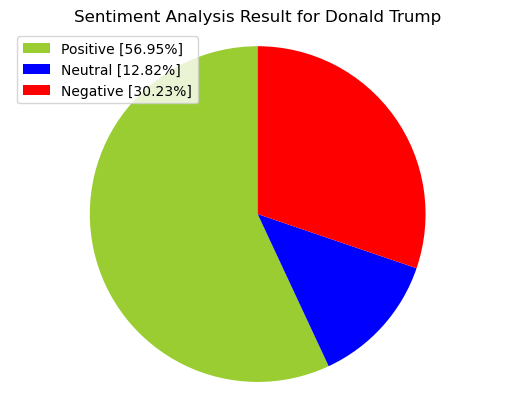

,Total,Percentage
positive,2506,56.95
negative,1330,30.23
neutral,564,12.82


In [20]:
#percentages of each sentiment
perc_trump=count_values_in_column(trump_eda,"sentiment")
perc_trump
#Creating PieCart-- sentiment for all tweets regardless of president
labels = ['Positive ['+str(perc_trump['Percentage'][0])+'%]' , 'Neutral ['+str(perc_trump['Percentage'][2])+'%]','Negative ['+str(perc_trump['Percentage'][1])+'%]']
sizes = [(perc_trump['Percentage'][0]),(perc_trump['Percentage'][2]),(perc_trump['Percentage'][1])]
colors = ['yellowgreen', 'blue','red']
patches, texts = plt.pie(sizes,colors=colors, startangle=90)
plt.style.use('default')
plt.legend(labels)
plt.title("Sentiment Analysis Result for Donald Trump" )
plt.axis('equal')
plt.show()
perc_trump

Word Cloud Saved Successfully


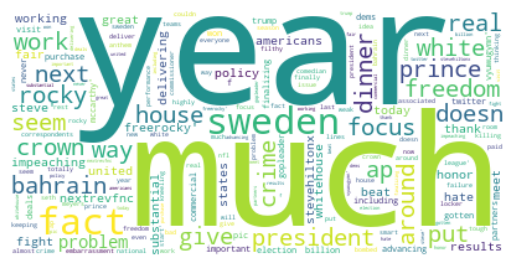

In [21]:
#Creating wordcloud
create_wordcloud(trump_eda["text_clean"].values)

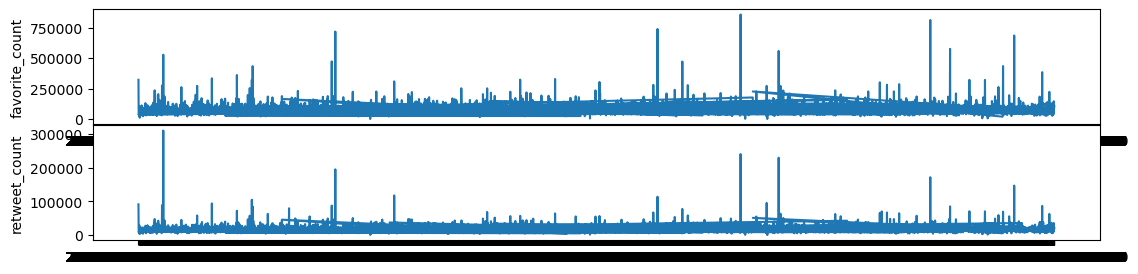

In [22]:
#EDA-- linechart
#favorite and retweet count over time

import matplotlib.pyplot as plt

ylabels = ["favorite_count","retweet_count"]
fig = plt.figure(figsize=(13,3))
fig.subplots_adjust(hspace=0.01,wspace=0.01)
n_row = len(ylabels)
n_col = 1
for count, ylabel in enumerate(ylabels):
    ax = fig.add_subplot(n_row,n_col,count+1)
    ax.plot(trump_eda["created_at"],trump_eda[ylabel])
    ax.set_ylabel(ylabel)
plt.show()

## Obama EDA

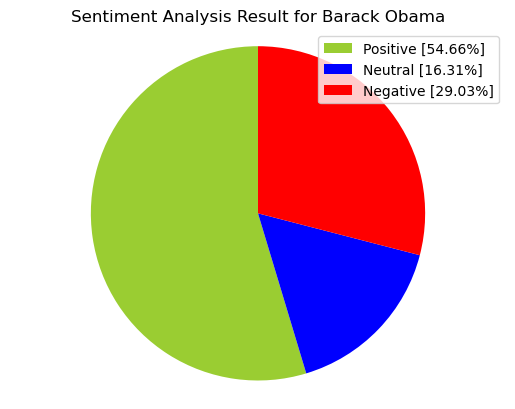

,Total,Percentage
positive,1049,54.66
neutral,557,29.03
negative,313,16.31


In [23]:
#percentages of each sentiment
perc_obama=count_values_in_column(obama_eda,"sentiment")
#Creating PieCart-- sentiment for all tweets regardless of president
labels = ['Positive ['+str(perc_obama['Percentage'][0])+'%]' , 'Neutral ['+str(perc_obama['Percentage'][2])+'%]','Negative ['+str(perc_obama['Percentage'][1])+'%]']
sizes = [(perc_obama['Percentage'][0]),(perc_obama['Percentage'][2]),(perc_obama['Percentage'][1])]
colors = ['yellowgreen', 'blue','red']
patches, texts = plt.pie(sizes,colors=colors, startangle=90)
plt.style.use('default')
plt.legend(labels)
plt.title("Sentiment Analysis Result for Barack Obama" )
plt.axis('equal')
plt.show()
perc_obama

Word Cloud Saved Successfully


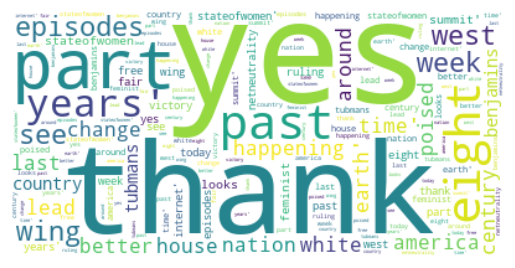

In [24]:
#Creating wordcloud
create_wordcloud(obama_eda["text_clean"].values)

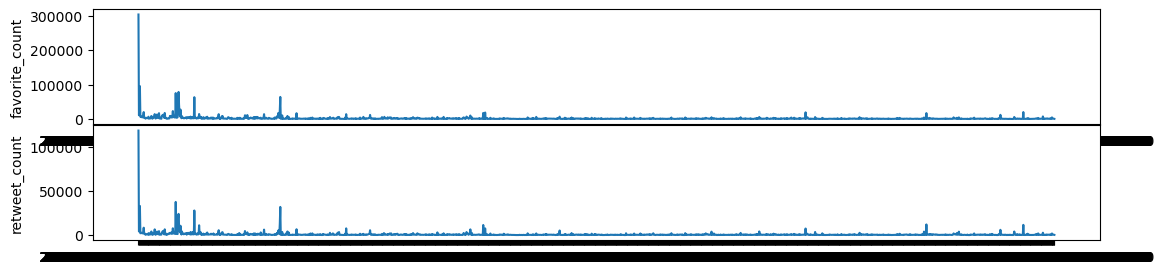

In [25]:
#EDA-- linechart
#favorite and retweet count over time

import matplotlib.pyplot as plt

ylabels = ["favorite_count","retweet_count"]
fig = plt.figure(figsize=(13,3))
fig.subplots_adjust(hspace=0.01,wspace=0.01)
n_row = len(ylabels)
n_col = 1
for count, ylabel in enumerate(ylabels):
    ax = fig.add_subplot(n_row,n_col,count+1)
    ax.plot(obama_eda["created_at"],obama_eda[ylabel])
    ax.set_ylabel(ylabel)
plt.show()

## Modelling
We will first try Naive Bayes Classifier, SVC, and Logistic Regression to see if we can predict whether the tweet is tweeted by Trump or not.

In [26]:
pres_all.head() #current data

,index,id,created_at,favorite_count,retweet_count,text,pres,text_clean,polarity,subjectivity,sentiment,neg,neu,pos,compound
0,38495,1154502673514684416,2019-07-25 23:24:21,323554,91622,give a ap rocky his freedom we do so much for...,Trump,give ap rocky freedom much sweden doesn seem w...,0.200,0.250000,negative,0.254,0.574,0.172,-0.2500
1,40738,1206445927021662208,2019-12-16 06:28:18,40060,10150,impeaching him they hate the fact above ...,Trump,impeaching hate fact president delivering subs...,-0.025,0.450000,positive,0.211,0.569,0.221,-0.1779
2,33184,936339260218724353,2017-11-30 22:00:50,41776,8695,today it was my great honor to meet with the ...,Trump,today great honor meet crown prince bahrain wh...,0.400,0.583333,positive,0.000,0.649,0.351,0.8979
3,32496,905582435538219011,2017-09-07 02:04:12,29668,5487,thank you for joining me in mandan nd gov ...,Trump,thank joining mandan nd gov dougburgum lt gov ...,0.000,0.000000,positive,0.000,0.839,0.161,0.3612
4,35922,1060949297900834816,2018-11-09 18:36:38,103784,29552,rick scott was up by 50 000 votes on election...,Trump,rick scott votes election day now found many v...,0.500,0.500000,neutral,0.000,1.000,0.000,0.0000


In [27]:
 #predicting 1 for trump's tweets and 0 for biden and obama
pres_all['target'] = np.where(pres_all['pres'] =='Trump', 1, 0) #creating target variable as stated above
df=pres_all.copy() #make deep copy for this stage of modelling
df=df.drop(columns=['sentiment','text'],axis=1) #drop repetitive columns
df=df.rename(columns={'text_clean':'text'})
df.head()

,index,id,created_at,favorite_count,retweet_count,pres,text,polarity,subjectivity,neg,neu,pos,compound,target
0,38495,1154502673514684416,2019-07-25 23:24:21,323554,91622,Trump,give ap rocky freedom much sweden doesn seem w...,0.200,0.250000,0.254,0.574,0.172,-0.2500,1
1,40738,1206445927021662208,2019-12-16 06:28:18,40060,10150,Trump,impeaching hate fact president delivering subs...,-0.025,0.450000,0.211,0.569,0.221,-0.1779,1
2,33184,936339260218724353,2017-11-30 22:00:50,41776,8695,Trump,today great honor meet crown prince bahrain wh...,0.400,0.583333,0.000,0.649,0.351,0.8979,1
3,32496,905582435538219011,2017-09-07 02:04:12,29668,5487,Trump,thank joining mandan nd gov dougburgum lt gov ...,0.000,0.000000,0.000,0.839,0.161,0.3612,1
4,35922,1060949297900834816,2018-11-09 18:36:38,103784,29552,Trump,rick scott votes election day now found many v...,0.500,0.500000,0.000,1.000,0.000,0.0000,1


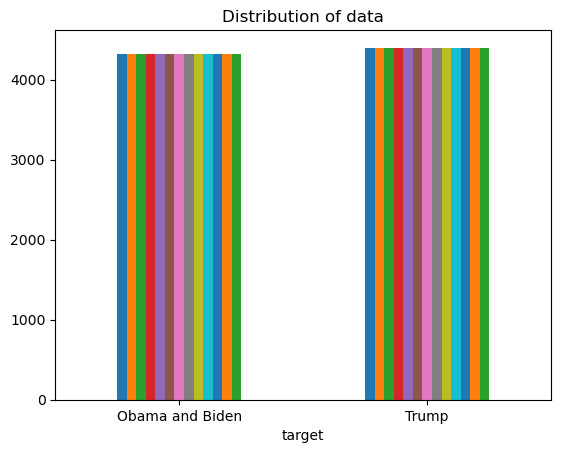

In [28]:
# Plotting the distribution for dataset.
ax = df.groupby('target').count().plot(kind='bar', title='Distribution of data',legend=False)
ax.set_xticklabels(['Obama and Biden','Trump'], rotation=0)
# Storing data in lists.
text, sentiment = list(df['text']), list(df['target'])

<AxesSubplot:xlabel='target', ylabel='count'>

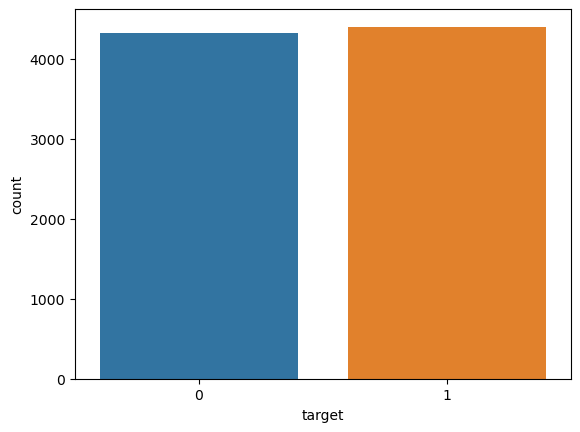

In [29]:
#alternative using seaborn
import seaborn as sns
sns.countplot(x='target', data=df)

In [30]:
#splitting data into pos and negative/neutral
df_pos = df[df['target'] == 1]
df_neg_or_neu = df[df['target'] == 0]

In [122]:
# tokenizing tweet text
from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer(r'\w+')
df['text'] = df['text'].apply(tokenizer.tokenize)
df['text'].head(20)

0     [give, ap, rocky, freedom, much, sweden, doesn...
1     [impeaching, hate, fact, president, delivering...
2     [today, great, honor, meet, crown, prince, bah...
3     [thank, joining, mandan, nd, gov, dougburgum, ...
4     [rick, scott, vote, election, day, now, found,...
5     [ve, saying, long, long, time, nokopic, twitte...
6     [heytammybruce, seems, personal, deeply, unfai...
7     [charles, koch, koch, brother, claim, giving, ...
8     [allegation, made, senator, jon, tester, admir...
9     [congratulation, brian, kemp, becoming, new, g...
10    [stock, market, hit, new, record, high, confid...
11    [buyamericanhireamerican, pic, twitter, rfaivvbg]
12    [medium, speculating, fired, rex, tillerson, l...
13    [will, green, bay, wisconsin, saturday, april,...
14    [today, florida, flotus, honored, welcome, mee...
15    [became, president, isi, control, syria, runni...
16    [jeff, session, said, wouldn, allow, politics,...
17    [call, shot, largely, based, accumulation,

In [124]:
# Apply stemming
import nltk

st = nltk.PorterStemmer()
def stemming_on_text(data):
    text = [st.stem(word) for word in data]
    return data
df['text']= df['text'].apply(lambda x: stemming_on_text(x))

In [125]:
# applying lemantizer
import nltk
nltk.download('wordnet')
lm = nltk.WordNetLemmatizer()
def lemmatizer_on_text(data):
    text = [lm.lemmatize(word) for word in data]
    return text
df['text'] = df['text'].apply(lambda x: lemmatizer_on_text(x))
df['text'].head()

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/mauratoner/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


0    [give, ap, rocky, freedom, much, sweden, doesn...
1    [impeaching, hate, fact, president, delivering...
2    [today, great, honor, meet, crown, prince, bah...
3    [thank, joining, mandan, nd, gov, dougburgum, ...
4    [rick, scott, vote, election, day, now, found,...
Name: text, dtype: object

In [34]:
#need text instead of list for vectorizing
df['text']=[" ".join(i) for i in df['text'].values]

# defining X and Y for train test split
X=df['text']
Y=df['target']

In [35]:
#train test split
# Separating 70/30
X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size = 0.30, random_state =1234)

In [36]:
#vectorizing transformation
vectoriser = TfidfVectorizer(ngram_range=(1,2), max_features=50000)
vectoriser.fit(X_train)
print('No. of feature_words: ', len(vectoriser.get_feature_names()))

No. of feature_words:  50000


In [37]:
#vectorize the train and test
X_train = vectoriser.transform(X_train)
X_test  = vectoriser.transform(X_test)

In [38]:
#CHECKING MODEL OUTCOMES
## We will create a function to address:
    #Accuracy
    #ROC curve/AUC
    #confusion matrix with plots
def model_Evaluate(model):
# Predict values for Test dataset
    y_pred = model.predict(X_test)
# Print the evaluation metrics for the dataset.
    print(classification_report(y_test, y_pred))
# Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(y_test, y_pred)
    categories = ['Negative','Positive']
    group_names = ['True Neg','False Pos', 'False Neg','True Pos']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]
    labels = [f'{v1}n{v2}' for v1, v2 in zip(group_names,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
                xticklabels = categories, yticklabels = categories)
    plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual values" , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

              precision    recall  f1-score   support

           0       0.92      0.98      0.95      1306
           1       0.98      0.92      0.95      1311

    accuracy                           0.95      2617
   macro avg       0.95      0.95      0.95      2617
weighted avg       0.95      0.95      0.95      2617



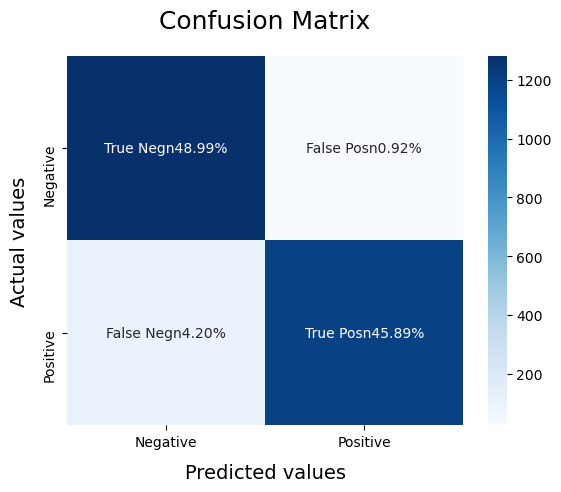

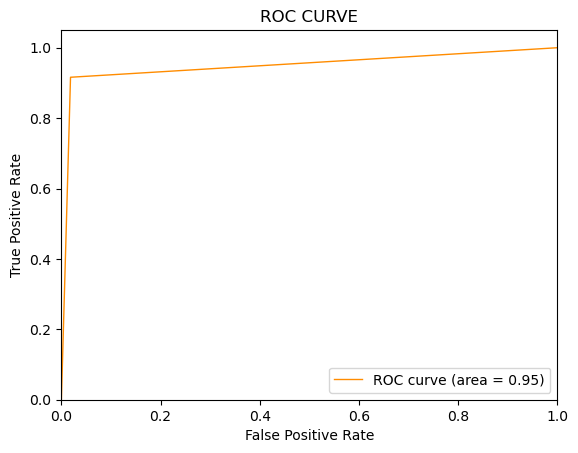

In [39]:
#Bernoulli Naive Bayes Model
BNBmodel = BernoulliNB()
BNBmodel.fit(X_train, y_train)
model_Evaluate(BNBmodel)
y_pred1 = BNBmodel.predict(X_test)

#Auc curve
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test, y_pred1)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC CURVE')
plt.legend(loc="lower right")
plt.show()

              precision    recall  f1-score   support

           0       0.94      0.96      0.95      1306
           1       0.96      0.94      0.95      1311

    accuracy                           0.95      2617
   macro avg       0.95      0.95      0.95      2617
weighted avg       0.95      0.95      0.95      2617



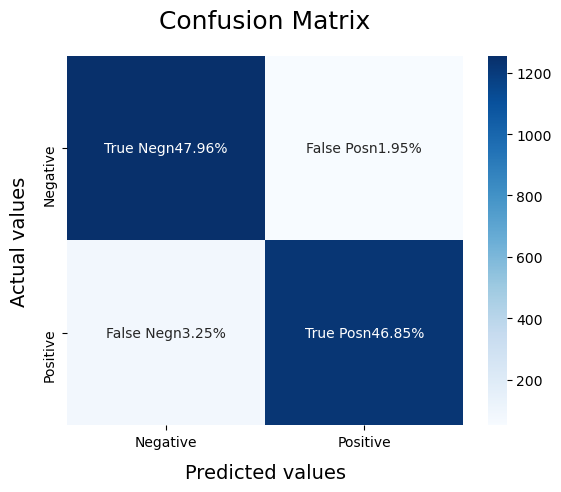

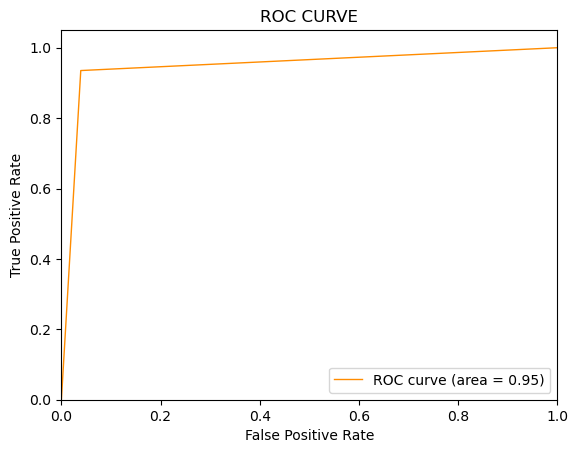

In [40]:

#SVC Model
# allows for string kernels and has potenital to be the best -- non-gaussian kernels whereas
#naive bayes has normality 
SVCmodel = LinearSVC()
SVCmodel.fit(X_train, y_train)
model_Evaluate(SVCmodel)
y_pred2 = SVCmodel.predict(X_test)

#ROC-AUC curve
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test, y_pred2)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC CURVE')
plt.legend(loc="lower right")
plt.show()

              precision    recall  f1-score   support

           0       0.93      0.96      0.94      1306
           1       0.95      0.93      0.94      1311

    accuracy                           0.94      2617
   macro avg       0.94      0.94      0.94      2617
weighted avg       0.94      0.94      0.94      2617



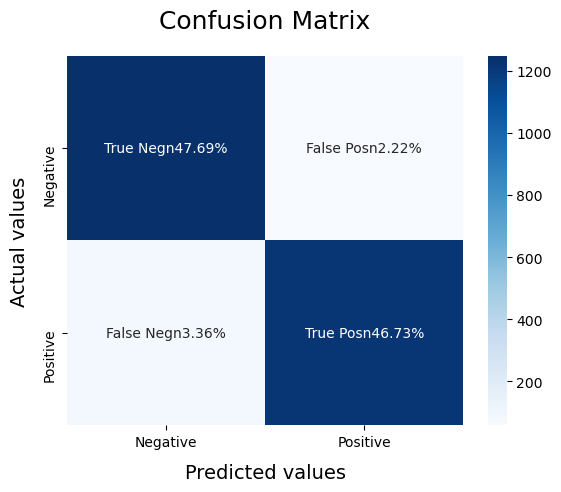

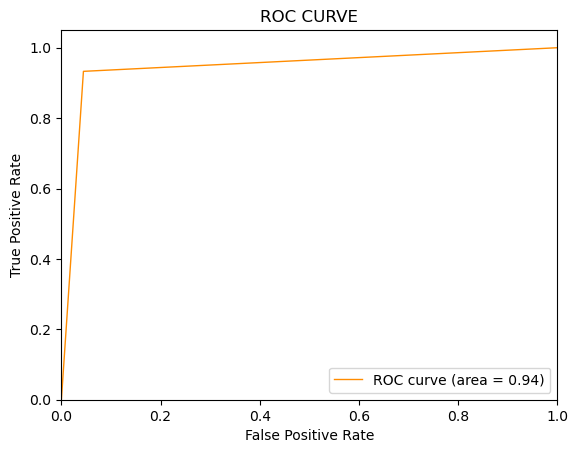

In [41]:
#Logicstic Regression
LRmodel = LogisticRegression(C = 2, max_iter = 1000, n_jobs=-1)
LRmodel.fit(X_train, y_train)
model_Evaluate(LRmodel)
y_pred3 = LRmodel.predict(X_test)

#ROC curve
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test, y_pred3)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC CURVE')
plt.legend(loc="lower right")
plt.show()

## Modelling 2: Random Forest
We will now analyze the favorites and retweets of the three presidents in three separate models. In each model, we will look at polarity and sentiment scores as the features. The outcome is retweets/favorites for each tweet. We can then analyze feature importance to see which parts of sentiment are important in determining tweet popularity.

In [80]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sklearn
from sklearn.metrics import *
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import *
from sklearn.ensemble import RandomForestClassifier
import seaborn as sn
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier

In [81]:
#we are doing a separate model for each president. need to divide up dataset
pres_all['fav/rt']=pres_all['favorite_count']/pres_all['retweet_count'] #new outcome variable

In [82]:
## dividing up by president
obama_df= pres_all[pres_all['pres']=='Obama']
biden_df= pres_all[pres_all['pres']=='Biden']
trump_df= pres_all[pres_all['pres']=='Trump']

## Biden Random Forest

In [83]:
biden_df.shape

(2402, 17)

In [84]:
## separating out variables and results
PredictorVars = biden_df[['neg','neu','pos','polarity']]
X = PredictorVars.values
print('Shape:',X.shape, '\n\n',X)

Shape: (2402, 4) 

 [[ 0.          1.          0.          0.10666667]
 [ 0.259       0.647       0.094       0.        ]
 [ 0.294       0.594       0.112      -0.15      ]
 ...
 [ 0.          1.          0.          0.        ]
 [ 0.114       0.653       0.233       0.10380952]
 [ 0.          1.          0.          0.        ]]


In [85]:
#result Variable (retweets to likes ratio)
#should normalize these values first for each president
ResultVar = biden_df['fav/rt']
Y = ResultVar.values
Y

array([7.28367206, 4.68804921, 5.55272465, ..., 6.82421403, 7.81684271,
       6.08793397])

In [86]:
#standardizing the data
X = StandardScaler().fit(X).transform(X.astype(float))

In [87]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.20, random_state = 0)

In [88]:
from sklearn.ensemble import RandomForestRegressor
#random forest regressor model
regressor = RandomForestRegressor(n_estimators = 100, random_state = 0)
 
# fit the regressor with x and y data
regressor.fit(X_train, Y_train) 

RandomForestRegressor(random_state=0)

In [91]:
importances = regressor.feature_importances_
std = np.std([tree.feature_importances_ for tree in regressor.estimators_], axis=0)

In [92]:
# predictions and evaluation metrics

# Use the forest's predict method on the test data
predictions = regressor.predict(X_test)
# Calculate the absolute errors
errors = abs(predictions - Y_test)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')

# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / Y_test)
# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')



Mean Absolute Error: 1.54 degrees.
Accuracy: 78.78 %.


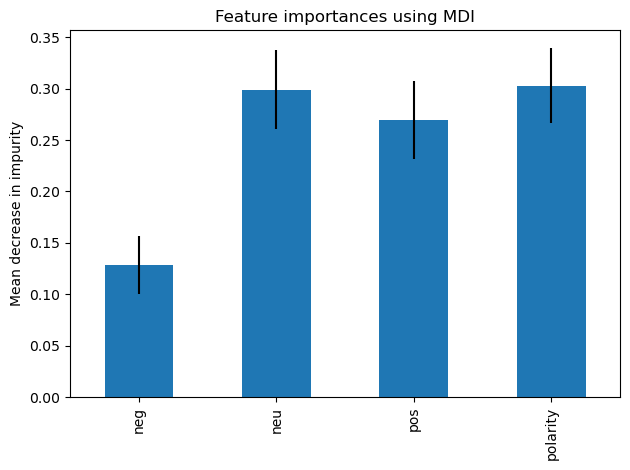

In [93]:
import pandas as pd

forest_importances = pd.Series(importances, index=PredictorVars.columns)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [94]:
from sklearn.inspection import permutation_importance

result = permutation_importance(
    regressor, X_test, Y_test, n_repeats=10, random_state=42, n_jobs=2
)
forest_importances = pd.Series(result.importances_mean, index=PredictorVars.columns)

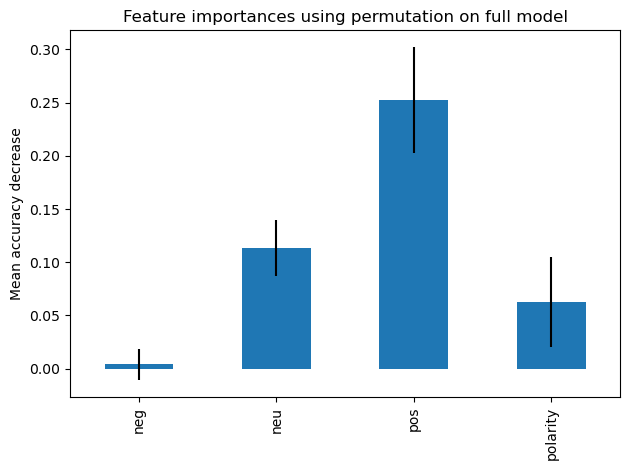

In [95]:
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

Text(0.5, 0, 'Random Forest Feature Importance')

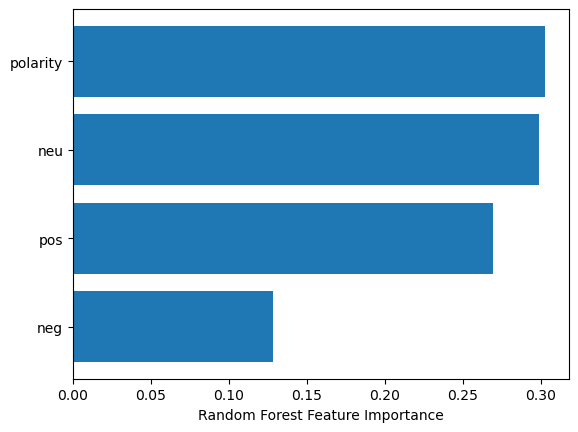

In [96]:
#sorted importance
sorted_idx = regressor.feature_importances_.argsort()
plt.barh(PredictorVars.columns[sorted_idx], regressor.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")

In [97]:
## can also add feature importance with shap values here

## Trump Random Forest

In [98]:
## separating out variables and results
PredictorVars = trump_df[['neg','neu','pos','polarity']]
X = PredictorVars.values
print('Shape:',X.shape, '\n\n',X)

Shape: (4400, 4) 

 [[ 0.254       0.574       0.172       0.2       ]
 [ 0.211       0.569       0.221      -0.025     ]
 [ 0.          0.649       0.351       0.4       ]
 ...
 [ 0.          0.709       0.291       0.        ]
 [ 0.255       0.672       0.073      -0.18452381]
 [ 0.269       0.651       0.08       -0.09637326]]


In [99]:
#result Variable (retweets to likes ratio)
#should normalize these values first for each president
ResultVar = trump_df['fav/rt']
Y = ResultVar.values
Y

array([3.53140076, 3.94679803, 4.80460035, ..., 5.0440442 , 4.96965453,
       5.08786253])

In [100]:
#standardizing the data
X = StandardScaler().fit(X).transform(X.astype(float))

In [101]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.20, random_state = 0)

In [102]:
from sklearn.ensemble import RandomForestRegressor
#random forest regressor model
regressor = RandomForestRegressor(n_estimators = 100, random_state = 0)
 
# fit the regressor with x and y data
regressor.fit(X_train, Y_train) 

RandomForestRegressor(random_state=0)

In [103]:
# predictions and evaluation metrics

# Use the forest's predict method on the test data
predictions = regressor.predict(X_test)
# Calculate the absolute errors
errors = abs(predictions - Y_test)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')

# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / Y_test)
# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')



Mean Absolute Error: 0.59 degrees.
Accuracy: 86.14 %.


In [104]:
importances = regressor.feature_importances_
std = np.std([tree.feature_importances_ for tree in regressor.estimators_], axis=0)

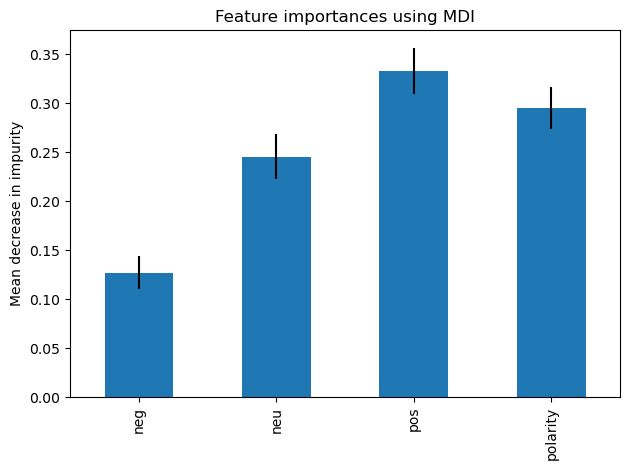

In [105]:
import pandas as pd

forest_importances = pd.Series(importances, index=PredictorVars.columns)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [106]:
from sklearn.inspection import permutation_importance

result = permutation_importance(
    regressor, X_test, Y_test, n_repeats=10, random_state=42, n_jobs=2
)
forest_importances = pd.Series(result.importances_mean, index=PredictorVars.columns)

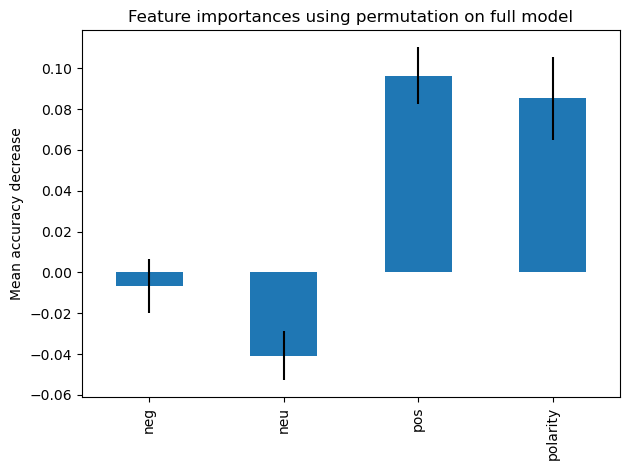

In [107]:
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

Text(0.5, 0, 'Random Forest Feature Importance')

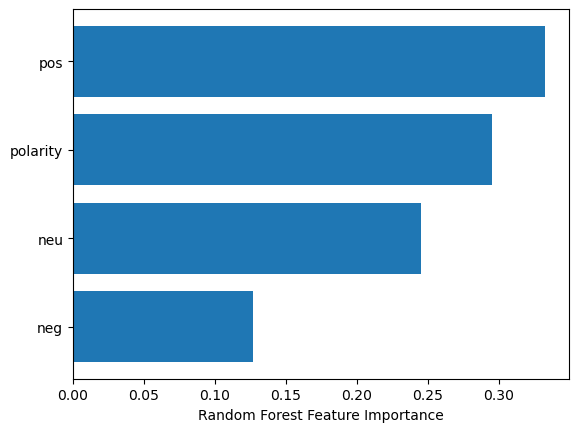

In [108]:
#sorted importance
sorted_idx = regressor.feature_importances_.argsort()
plt.barh(PredictorVars.columns[sorted_idx], regressor.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")

## Obama Random Forest

In [109]:
## separating out variables and results
PredictorVars = obama_df[['neg','neu','pos','polarity']]
X = PredictorVars.values
print('Shape:',X.shape, '\n\n',X)

Shape: (1919, 4) 

 [[ 0.     0.336  0.664 -0.25 ]
 [ 0.     1.     0.     0.   ]
 [ 0.     0.588  0.412  0.5  ]
 ...
 [ 0.     1.     0.     0.   ]
 [ 0.     1.     0.     0.   ]
 [ 0.     0.472  0.528  0.55 ]]


In [110]:
#result Variable (retweets to likes ratio)
#should normalize these values first for each president
ResultVar = obama_df['fav/rt']
Y = ResultVar.values
Y

array([2.56831603, 2.6503023 , 2.93472542, ..., 2.19329389, 2.24285714,
       1.92125984])

In [111]:
#standardizing the data
X = StandardScaler().fit(X).transform(X.astype(float))

In [112]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.20, random_state = 0)

In [113]:
from sklearn.ensemble import RandomForestRegressor
#random forest regressor model
regressor = RandomForestRegressor(n_estimators = 100, random_state = 0)
 
# fit the regressor with x and y data
regressor.fit(X_train, Y_train) 

RandomForestRegressor(random_state=0)

In [114]:
importances = regressor.feature_importances_
std = np.std([tree.feature_importances_ for tree in regressor.estimators_], axis=0)

In [115]:
# predictions and evaluation metrics

# Use the forest's predict method on the test data
predictions = regressor.predict(X_test)
# Calculate the absolute errors
errors = abs(predictions - Y_test)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')

# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / Y_test)
# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

Mean Absolute Error: 0.59 degrees.
Accuracy: 75.09 %.


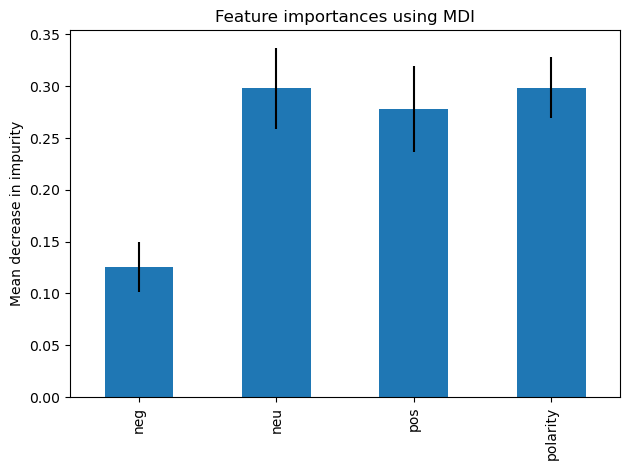

In [116]:
import pandas as pd

forest_importances = pd.Series(importances, index=PredictorVars.columns)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [117]:
from sklearn.inspection import permutation_importance

result = permutation_importance(
    regressor, X_test, Y_test, n_repeats=10, random_state=42, n_jobs=2
)
forest_importances = pd.Series(result.importances_mean, index=PredictorVars.columns)

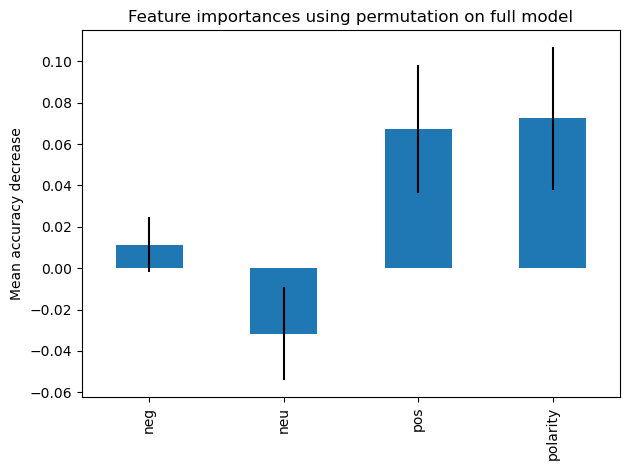

In [118]:
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

Text(0.5, 0, 'Random Forest Feature Importance')

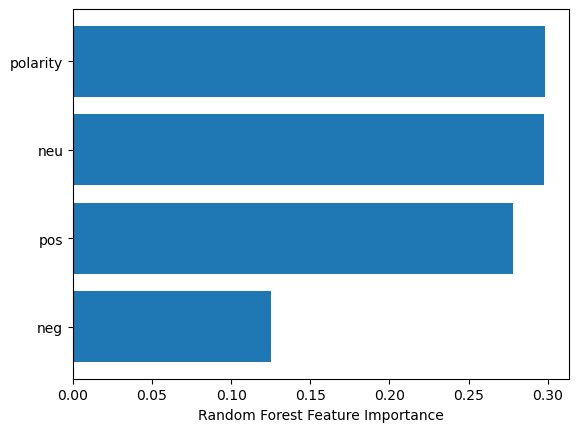

In [119]:
#sorted importance
sorted_idx = regressor.feature_importances_.argsort()
plt.barh(PredictorVars.columns[sorted_idx], regressor.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")

## Numeric Summaries


In [120]:
print('Obama Favorites:')
obama_eda.favorite_count.min(), obama_eda.favorite_count.max(),obama_eda.favorite_count.mean(),obama_eda.favorite_count.median()
print('\n',)

Obama Favorites:


